In [26]:
%env DGL_LIBRARY_PATH=/data/jinjing/dgl/build
%pylab inline
%config InlineBackend.figure_format = 'svg'

import torch as th
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import dgl
import networkx as nx


def update_edge(u, v, edge):
    return {'b_ij': edge['b_ij'] + (v['h'] * edge['u_hat']).sum(dim=1)}


def v2_reduce(node, msg):
    b_ij_c, u_hat = msg['b_ij'], msg['u_hat']
    c_i = F.softmax(b_ij_c, dim=0)
    s_j = (c_i.unsqueeze(2) * u_hat).sum(dim=1)
    return {'s_j': s_j}


def capsule_msg(src, edge):
    return {'b_ij': edge['b_ij'], 'h': src['h'], 'u_hat': edge['u_hat']}


def squash(s):
    s = s['s_j']
    msg_sq = th.sum(s**2, dim=1, keepdim=True)
    msg = th.sqrt(msg_sq)
    s = (msg_sq / (1.0 + msg_sq)) * (s / msg)
    return {'h': s}


np.random.seed(10)
num_points = 10
num_points2 = 2

theta_dist1 = np.pi * (np.random.rand(num_points) * 2)

radius_1 = np.random.rand(num_points) * 2 + 3
points_1 = th.from_numpy(
    np.array([np.cos(theta_dist1) * radius_1,
              np.sin(theta_dist1) * radius_1])).float()

env: DGL_LIBRARY_PATH=/data/jinjing/dgl/build
Populating the interactive namespace from numpy and matplotlib


In [27]:
g = dgl.DGLGraph()
g.add_nodes(num_points + num_points2)

for i in range(num_points):
    for j in range(num_points2):
        g.add_edge(i, j + num_points)

nodes1 = list(range(num_points))
nodes2 = list(range(num_points, num_points + num_points2))

In [28]:
W = th.randn((num_points2, num_points, 2, 2))
u_hat = th.matmul(points_1.t().unsqueeze(1), W).squeeze(2).view(-1, 2)

In [29]:
points_1.t().unsqueeze(1).shape

torch.Size([10, 1, 2])

In [30]:
u_hat.shape

torch.Size([20, 2])

In [31]:
g.set_n_repr({'h': th.cat([points_1, th.zeros((2, num_points2))], dim=1).t()})
g.set_e_repr({'b_ij': th.zeros(g.number_of_edges()).float()})
g.set_e_repr({'u_hat': u_hat})

/home/jinjing/.pyenv/versions/3.6.1/lib/python3.6/site-packages/dgl-0.0.1-py3.6.egg/dgl/frame.py:256: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  dgl_warning('Initializer is not set. Use zero initializer instead.'


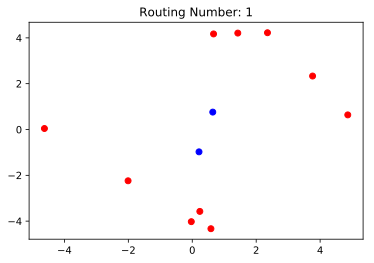

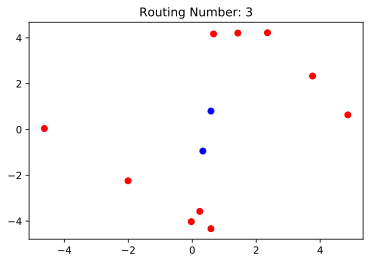

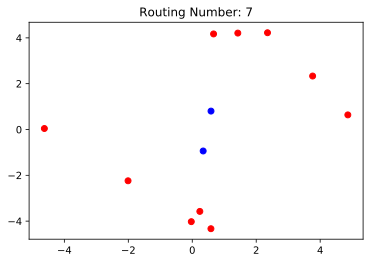

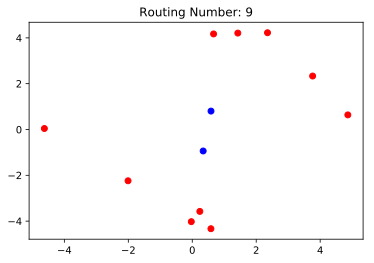

In [32]:
iterations=10
selected_node_feats=[points_1.data.numpy().T]
for i in range(iterations):
    g.update_all(capsule_msg, v2_reduce, squash)
    g.update_edge(edge_func=update_edge)
    
    new_=g.get_n_repr()['h'][num_points:num_points+num_points2]
    np_new=new_.data.numpy()
    if i in (1,3,7,9):
        selected_node_feats.append(np_new)
        plt.scatter(*np_new.T,color='blue')
        plt.scatter(*points_1, color='red')
        plt.title(f"Routing Number: {i}")
        plt.show()

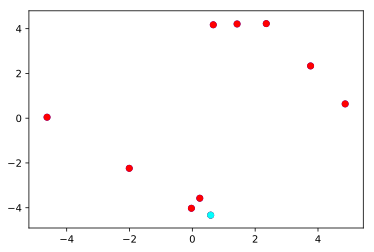

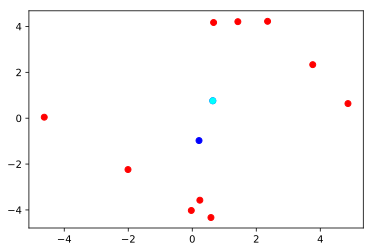

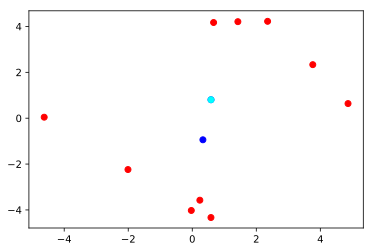

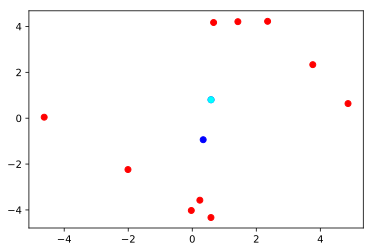

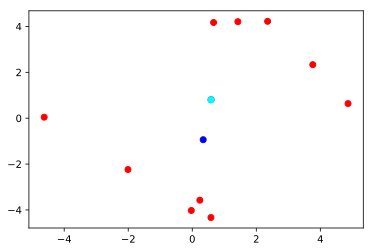

In [33]:
for feats in selected_node_feats:
    plt.scatter(*feats.T,color='blue')
    plt.scatter(*points_1, color='red')
    plt.scatter(*feats[0].T, color='aqua')
    plt.show()